## To demonstrate how to implement feature selections step by step

#### Last update: 20190803

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import (RandomForestClassifier,
                              RandomForestRegressor)
from sklearn.metrics import (confusion_matrix, 
                             accuracy_score, 
                             roc_auc_score)
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import RFE
from sklearn.linear_model import (Lasso, 
                                  LinearRegression, 
                                  Ridge)
from sklearn.preprocessing import MinMaxScaler

## PART 1. Explore input data

#### Read input data

test.csv file is an example data that has 10 features (from x0 to x9), and one class label which is either 1 or -1

In [2]:
df = pd.read_csv('test.csv', encoding='utf-8')

#### Quick look about data

In [3]:
df.head()

,label,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9
0,1.0,0.834251,0.726081,0.535904,0.214896,0.873788,0.767605,0.111308,0.557526,0.599650,0.665569
1,1.0,0.804059,0.253135,0.869867,0.334285,0.604075,0.494045,0.833575,0.194190,0.014966,0.802918
2,1.0,0.694404,0.595777,0.581294,0.799003,0.762857,0.651393,0.075905,0.007186,0.659633,0.831009
3,1.0,0.783690,0.038780,0.285043,0.627305,0.800620,0.486340,0.827723,0.339807,0.731343,0.892359
4,1.0,0.788835,0.174433,0.348770,0.938244,0.692065,0.377620,0.183760,0.616805,0.492899,0.930969


In [4]:
df.columns

Index(['label', 'x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9'], dtype='object')

In [5]:
len(df) # number of samples

400

#### Get X and y

In [6]:
y = df['label']
ignore_cols = ['label']
X = df.drop(ignore_cols, axis=1)

#### Quick look on y and X

In [7]:
y.value_counts()

-1.0    200
 1.0    200
Name: label, dtype: int64

In [8]:
X.describe()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9
count,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000
mean,0.523661,0.509223,0.481238,0.509752,0.497875,0.501065,0.490480,0.482372,0.482822,0.541933
std,0.268194,0.276878,0.287584,0.297712,0.288208,0.287634,0.289954,0.282714,0.296180,0.272490
min,0.007775,0.003865,0.004473,0.001466,0.000250,0.000425,0.000173,0.003322,0.003165,0.000452
25%,0.299792,0.283004,0.235544,0.262697,0.249369,0.269430,0.226687,0.242848,0.213626,0.321264
50%,0.534906,0.507583,0.460241,0.510066,0.497842,0.497108,0.477341,0.463438,0.462251,0.578389
75%,0.751887,0.727843,0.734937,0.768975,0.743401,0.738854,0.735304,0.732483,0.740542,0.768990
max,0.999476,0.998680,0.992963,0.995119,0.999412,0.997367,0.997141,0.998230,0.996098,0.999465


#### As can be seen above, there are no extreme cases from x0 to x9 features, such as their mean and std values, etc


#### Let's look at X more details using seaborn

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\contour.py:960: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\contour.py:960: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\contour.py:960: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\contour.py:960: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\contour.py:960: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\contour.py:960: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\contour.py:960: UserWarning: The f

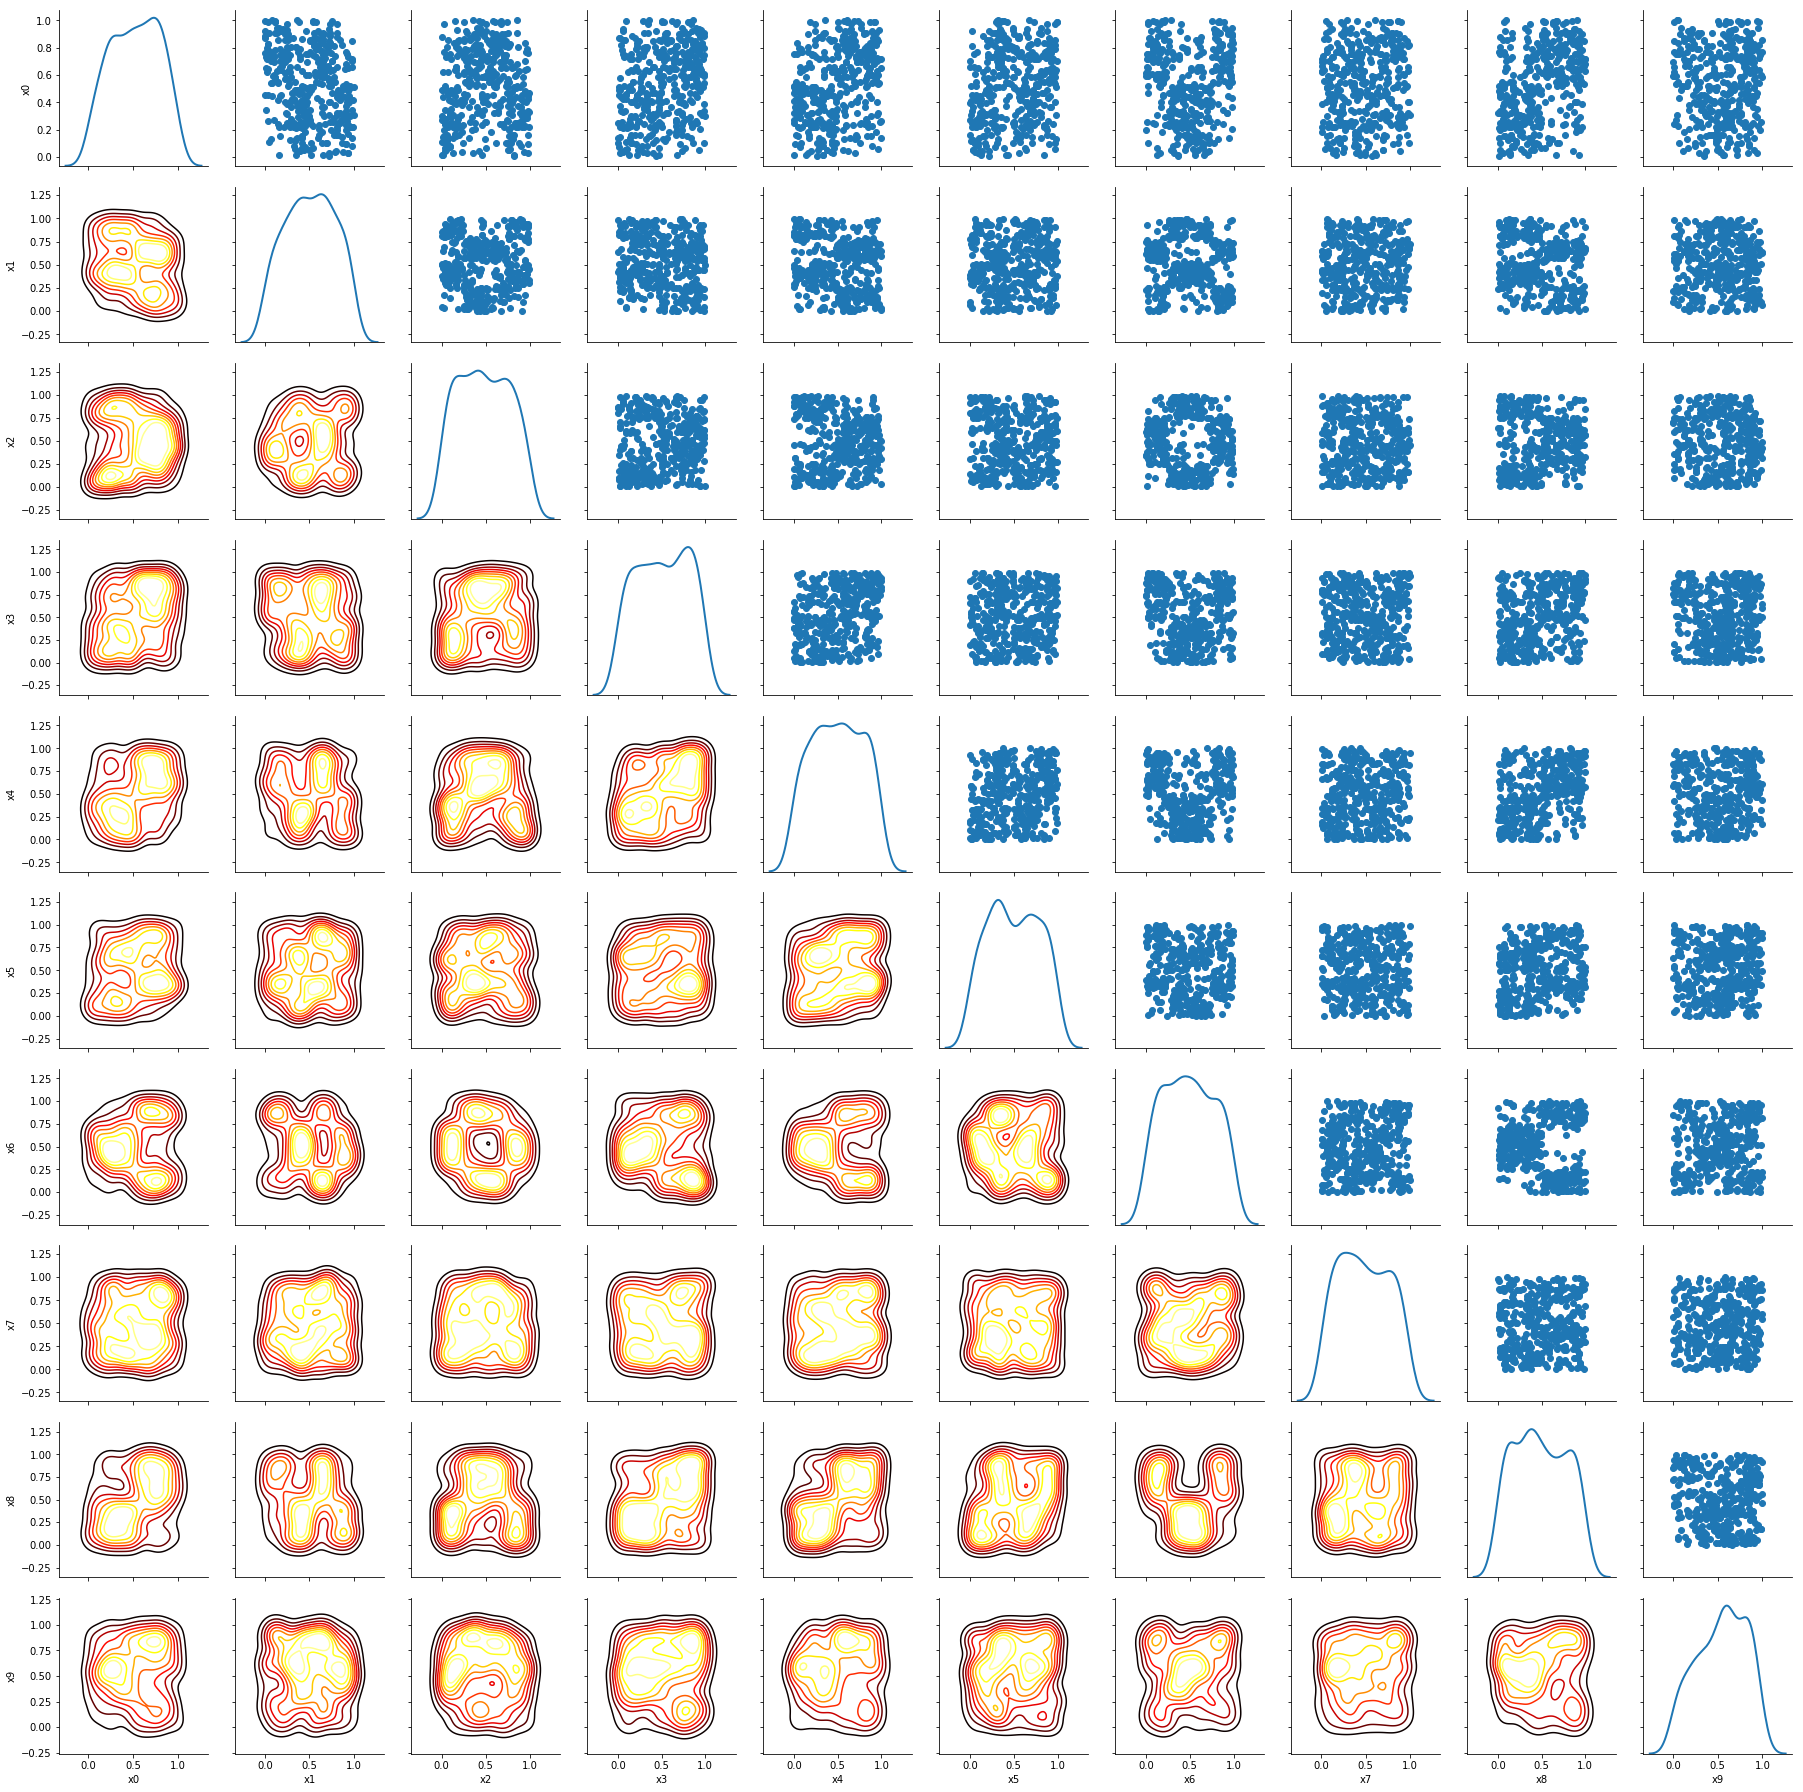

In [9]:
# seaborn.PairGrid: refer to https://seaborn.pydata.org/generated/seaborn.PairGrid.html
g = sns.PairGrid(X, diag_sharey=False)
g.map_lower(sns.kdeplot, cmap=plt.cm.hot)
g.map_upper(plt.scatter)
g.map_diag(sns.kdeplot, lw=2)

#### As can be seen from the PairGrid plot above, we cannot observe any strong correlations among features. 
(lets make sure by calculating R2 and display as a heatmap) 

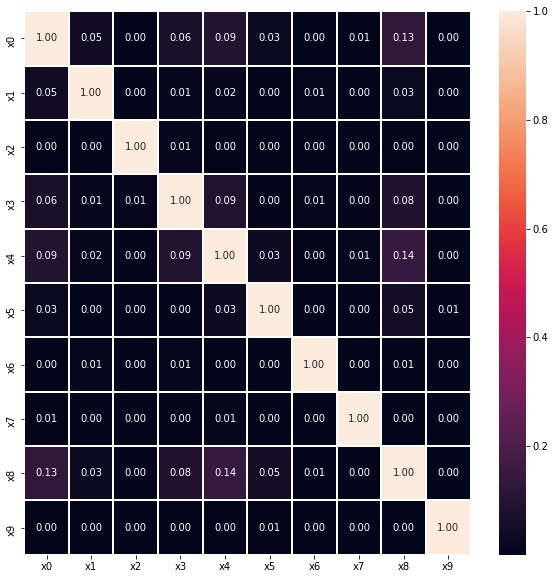

In [10]:
f, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(X.corr()*X.corr(),
            annot=True,
            linewidths=1,
            fmt='.2f',
            ax=ax)

#### Now look at the violinplot of X features with respected to y label

In [11]:
# Concat X and y
data = pd.concat([y, X], axis=1)
data.head()

,label,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9
0,1.0,0.834251,0.726081,0.535904,0.214896,0.873788,0.767605,0.111308,0.557526,0.599650,0.665569
1,1.0,0.804059,0.253135,0.869867,0.334285,0.604075,0.494045,0.833575,0.194190,0.014966,0.802918
2,1.0,0.694404,0.595777,0.581294,0.799003,0.762857,0.651393,0.075905,0.007186,0.659633,0.831009
3,1.0,0.783690,0.038780,0.285043,0.627305,0.800620,0.486340,0.827723,0.339807,0.731343,0.892359
4,1.0,0.788835,0.174433,0.348770,0.938244,0.692065,0.377620,0.183760,0.616805,0.492899,0.930969


In [12]:
# Unpivot data using melt() function in pandas 
data = pd.melt(data, 
               id_vars="label",
               var_name="features",
               value_name='value')
data.head()

,label,features,value
0,1.0,x0,0.834251
1,1.0,x0,0.804059
2,1.0,x0,0.694404
3,1.0,x0,0.783690
4,1.0,x0,0.788835


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

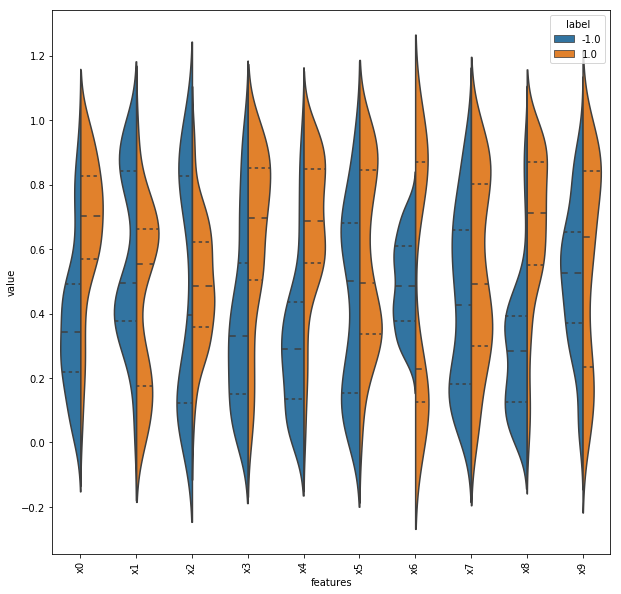

In [13]:
plt.figure(figsize=(10, 10))
sns.violinplot(data=data,
               x='features',
               y='value',
               hue = 'label', # hue means colorby as in Spotfire
               split=True,
               inner = 'quart')
plt.xticks(rotation=90)

#### The violinplot above indicates that the distributions of features corresponding to each label in "lable" column are far from normal distribution. Furthermore, it looks like that all the features are good for classification

#### An alternative way is looking at boxplot, in which one can see the median and 1D outliers (if having) clearer. So let's draw boxplot using seaborn

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

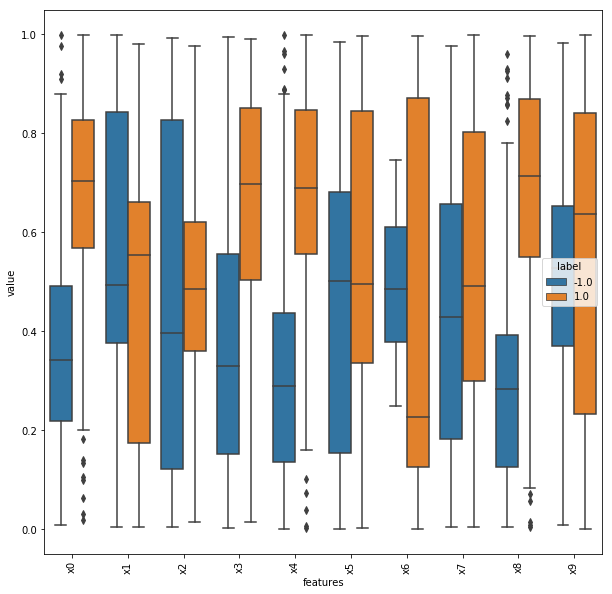

In [14]:
plt.figure(figsize=(10, 10))
sns.boxplot(x='features',
            y='value',
            hue = 'label',
            data=data)
plt.xticks(rotation=90)

#### Another way to observe whether or not a feature is good for classification is to see at the swarm plot. So let's plot it.

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

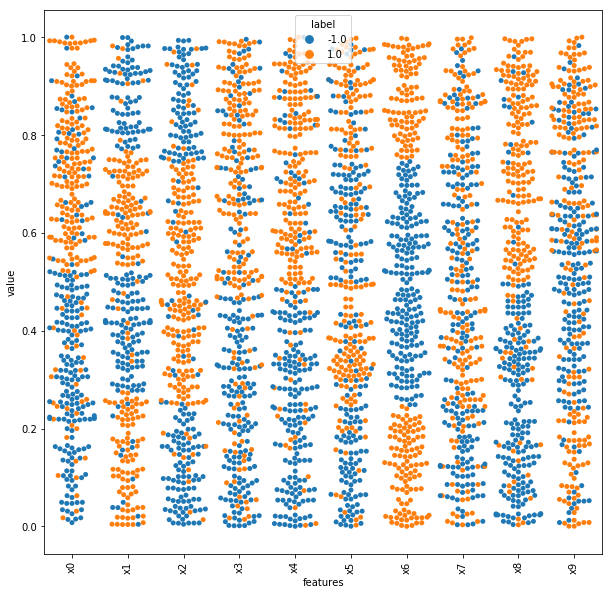

In [15]:
plt.figure(figsize=(10, 10))
sns.swarmplot(data=data,
              x='features',
              y='value',
              hue = 'label')
plt.xticks(rotation=90)

#### As can be seen from the swarm plot above, all features looks good to be used for classification. 
#### x6, x1, x4, x8 and x2 look very good for classification (especially x6, which looks perfect for classification). However, there is a little bit suspected at x3, x7 and x9 since their data points are "mixing" at label=1 and label=-1.

### Using all festures (x0 to x9). Lets use Random Forest to test

X_train.shape=(320, 10), X_test.shape=(80, 10), y_train.shape=(320,), y_test.shape=(80,)
Accuracy is:  0.975


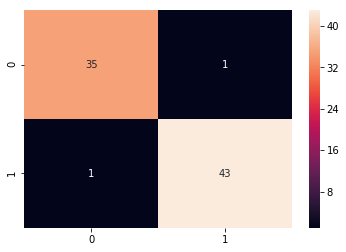

In [16]:
# split data train 80 % and test 20 %
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print('X_train.shape={}, X_test.shape={}, y_train.shape={}, y_test.shape={}'
      .format(X_train.shape, X_test.shape, y_train.shape, y_test.shape)) 

#random forest classifier with n_estimators=100 (default)
clf_rf = RandomForestClassifier(random_state=43)      
clr_rf = clf_rf.fit(X_train, y_train)

ac = accuracy_score(y_test, clf_rf.predict(X_test))
print('Accuracy is: ', ac)
cm = confusion_matrix(y_test, clf_rf.predict(X_test))
sns.heatmap(cm, 
            annot=True, 
            fmt="d")

#### As can be seen above, accuracy is 97.5% and in confusion matrix, we make very few wrong prediction. Now lets see some feature selection methods to see whether or not we can have better results.

## PART 2. Feature Selection: Filter method

#### Based on quick analysis in Part 1, in this part we don't need to consider some methods such as variance and correlation. 

### Univariate ROC_AUC method

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((320, 10), (80, 10), (320,), (80,))

In [18]:
def univariate_roc_auc(X_train, X_test, y_train, y_test):
    """
    This method is to build one decision tree per feature to predict the target, 
    and then make predictions and ranks the features based on a metric such as ROC-AUC or MSE
    """
    roc_values = []
    for feature in X_train.columns:
        clf = DecisionTreeClassifier()
        clf.fit(X_train[feature].to_frame(), y_train)
        y_scored = clf.predict_proba(X_test[feature].to_frame())
        roc_values.append(roc_auc_score(y_test, y_scored[:, 1]))
    roc_values = pd.Series(roc_values)
    roc_values.index = X_train.columns
    return roc_values.sort_values(ascending=False)

uni_roc_auc = univariate_roc_auc(X_train, X_test, y_train, y_test)
print('Ranking    AUC')
print(uni_roc_auc)

Ranking    AUC
x6    0.988636
x1    0.848485
x2    0.787879
x4    0.737058
x8    0.725379
x0    0.688447
x5    0.637942
x9    0.559975
x7    0.538194
x3    0.505682
dtype: float64


#### The results here are quite consistent with the analysis in part 1 (the swarm plot analysis).

### Test results based on number of features

shape of X_train_1 =(320, 4), shape of X_test_1 = (80, 4)


Accuracy=0.9875 at features=['x6', 'x1', 'x2', 'x4']


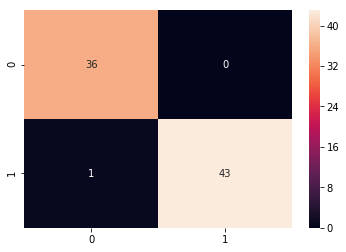

In [19]:
list_cols_top = ['x6', 'x1', 'x2', 'x4'] #, 'x8', 'x0', 'x5', 'x9', 'x7', 'x3']
X_train_1, X_test_1 = X_train[list_cols_top], X_test[list_cols_top]
print('shape of X_train_1 ={}, shape of X_test_1 = {}'.format(X_train_1.shape, X_test_1.shape))

#random forest classifier with n_estimators=100 (default)
clf_rf = RandomForestClassifier(random_state=43)      
clr_rf = clf_rf.fit(X_train_1, y_train)

ac = accuracy_score(y_test, clf_rf.predict(X_test_1))
print('\n\nAccuracy={} at features={}'.format(ac, list_cols_top))
cm = confusion_matrix(y_test, clf_rf.predict(X_test_1))
sns.heatmap(cm, annot=True, fmt="d")

>* Accuracy=0.9875 at features=['x6']
* Accuracy=0.9750 at features=['x6', 'x1']
* Accuracy=0.9750 at features=['x6', 'x1', 'x2']
* Accuracy=0.9875 at features=['x6', 'x1', 'x2', 'x4']
* Accuracy=0.9750 at features=['x6', 'x1', 'x2', 'x4', 'x8']
* Accuracy=0.9620 at features=['x6', 'x1', 'x2', 'x4', 'x8', 'x0']
* Accuracy=0.9750 at features=['x6', 'x1', 'x2', 'x4', 'x8', 'x0', 'x5']
* Accuracy=0.9875 at features=['x6', 'x1', 'x2', 'x4', 'x8', 'x0', 'x5', 'x9']
* Accuracy=0.9620 at features=['x6', 'x1', 'x2', 'x4', 'x8', 'x0', 'x5', 'x9', 'x7']
* Accuracy=0.9750 at features=['x6', 'x1', 'x2', 'x4', 'x8', 'x0', 'x5', 'x9', 'x7', 'x3']
* Accuracy=0.8375 at features=['x1']
* Accuracy=0.7750 at features=['x2']
* Accuracy=0.5000 at features=['x3']
* Accuracy=0.7625 at features=['x4']
* Accuracy=0.6250 at features=['x5']
* Accuracy=0.5620 at features=['x7']
* Accuracy=0.7750 at features=['x8']
* Accuracy=0.5500 at features=['x9']
>


## Part 3. Feature Selection: Random Forest Importance

Feature ranking:
Rank 1. feature name:x6 (0.283595)
Rank 2. feature name:x4 (0.223567)
Rank 3. feature name:x8 (0.165509)
Rank 4. feature name:x0 (0.144674)
Rank 5. feature name:x3 (0.060599)
Rank 6. feature name:x2 (0.036430)
Rank 7. feature name:x1 (0.030416)
Rank 8. feature name:x5 (0.021500)
Rank 9. feature name:x9 (0.018366)
Rank 10. feature name:x7 (0.015344)
importances[indices] =  [0.28359504 0.22356664 0.16550939 0.14467382 0.06059885 0.0364304
 0.03041596 0.02149977 0.01836648 0.01534367] <class 'numpy.ndarray'>


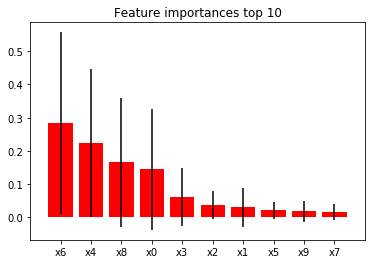

In [20]:
def random_forest_importance(X_train, y_train, max_depth=10, class_weight=None, 
                             top_n=10, n_estimators=20, random_state=0):
    
    model = RandomForestClassifier(n_estimators=n_estimators,
                                   max_depth=max_depth,
                                   random_state=random_state,
                                   class_weight=class_weight,
                                   n_jobs=-1)
    model.fit(X_train, y_train)
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    feat_labels = X_train.columns
    std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0) #  inter-trees variability. 
    print("Feature ranking:") 
    for f in range(X_train.shape[1]):
        print("Rank %d. feature name:%s (%f)" % (f + 1, feat_labels[indices[f]], importances[indices[f]]))

    indices = indices[0:top_n]
    plt.figure()
    plt.title("Feature importances top %d" % top_n)
    
    print('importances[indices] = ', importances[indices], type(importances[indices]))
    
    plt.bar(x=range(top_n), 
            height=importances[indices],
            color="r", 
            yerr=std[indices], 
            align="center")
    plt.xticks(range(top_n), 
               ('x' + str(i) for i in indices) # to show feature name
              )
    plt.xlim([-1, top_n])
    plt.show() 
    return model

model = random_forest_importance(X_train=X_train,
                                 y_train=y_train, 
                                 max_depth=10,
                                 top_n=10)

#### The results here are also consistent with the analysis in part 1 (the swarm plot analysis).

## PART 4. Feature Selection Other methods

In [21]:
ranks = {}

def ranking(ranks, col_names, order=1):
    min_max = MinMaxScaler()
    ranks = min_max.fit_transform(order*np.array([ranks]).T).T[0]
    ranks = map(lambda x: round(x,2), ranks)
    return dict(zip(col_names, ranks))

### 4.1.  Recursive Feature Elimination ( RFE )

In [22]:
lr = LinearRegression(normalize=True)
lr.fit(X_train, y_train)
#stop the search when only the last feature is left
rfe = RFE(lr, n_features_to_select=1, verbose =3 )
rfe.fit(X_train, y_train)
ranks["RFE"] = ranking(list(map(float, rfe.ranking_)), col_names=X_train.columns, order=-1)
print('rank_RFE = ', ranks["RFE"])

Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
rank_RFE =  {'x0': 0.78, 'x1': 0.33, 'x2': 0.0, 'x3': 0.67, 'x4': 0.89, 'x5': 0.22, 'x6': 0.11, 'x7': 0.56, 'x8': 1.0, 'x9': 0.44}


### 4.2. Linear model feature ranking

In [23]:
# Using Linear Regression
lr = LinearRegression(normalize=True)
lr.fit(X_train,y_train)
ranks["LinReg"] = ranking(np.abs(lr.coef_), col_names=X_train.columns)

# Using Ridge 
ridge = Ridge(alpha = 7)
ridge.fit(X_train,y_train)
ranks['Ridge'] = ranking(np.abs(ridge.coef_), col_names=X_train.columns)

# Using Lasso
lasso = Lasso(alpha=.05)
lasso.fit(X_train,y_train)
ranks["Lasso"] = ranking(np.abs(lasso.coef_), col_names=X_train.columns)

print('ranks = ', ranks)

ranks =  {'RFE': {'x0': 0.78, 'x1': 0.33, 'x2': 0.0, 'x3': 0.67, 'x4': 0.89, 'x5': 0.22, 'x6': 0.11, 'x7': 0.56, 'x8': 1.0, 'x9': 0.44}, 'LinReg': {'x0': 0.67, 'x1': 0.18, 'x2': 0.0, 'x3': 0.5, 'x4': 0.97, 'x5': 0.05, 'x6': 0.01, 'x7': 0.25, 'x8': 1.0, 'x9': 0.22}, 'Ridge': {'x0': 0.69, 'x1': 0.23, 'x2': 0.01, 'x3': 0.57, 'x4': 0.97, 'x5': 0.12, 'x6': 0.0, 'x7': 0.25, 'x8': 1.0, 'x9': 0.2}, 'Lasso': {'x0': 0.52, 'x1': 0.0, 'x2': 0.0, 'x3': 0.35, 'x4': 0.93, 'x5': 0.0, 'x6': 0.0, 'x7': 0.0, 'x8': 1.0, 'x9': 0.0}}


### 4.3. Random Forest feature ranking

In [24]:
rf = RandomForestRegressor(n_jobs=-1, n_estimators=50, verbose=3)
rf.fit(X_train, y_train)
ranks["RF"] = ranking(rf.feature_importances_, col_names=X_train.columns);
print('rank_RF = \n', ranks["RF"])

building tree 1 of 50building tree 2 of 50
building tree 3 of 50
building tree 4 of 50

building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50building tree 14 of 50

building tree 15 of 50building tree 16 of 50

building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.0s finished


rank_RF = 
 {'x0': 0.12, 'x1': 0.06, 'x2': 0.06, 'x3': 0.03, 'x4': 0.53, 'x5': 0.0, 'x6': 0.69, 'x7': 0.0, 'x8': 1.0, 'x9': 0.0}


### Summary part 4

In [25]:
col_names = X_train.columns
r = {}
for col_name in col_names:
    r[col_name] = round(np.mean([ranks[method][col_name] 
                             for method in ranks.keys()]), 2)
 
methods = sorted(ranks.keys())
ranks["Mean"] = r
methods.append("Mean")
 
print("\t%s" % "\t".join(methods))
for col_name in col_names:
    print("%s\t%s" % (col_name, "\t".join(map(str, 
                         [ranks[method][col_name] for method in methods]))))

	Lasso	LinReg	RF	RFE	Ridge	Mean
x0	0.52	0.67	0.12	0.78	0.69	0.56
x1	0.0	0.18	0.06	0.33	0.23	0.16
x2	0.0	0.0	0.06	0.0	0.01	0.01
x3	0.35	0.5	0.03	0.67	0.57	0.42
x4	0.93	0.97	0.53	0.89	0.97	0.86
x5	0.0	0.05	0.0	0.22	0.12	0.08
x6	0.0	0.01	0.69	0.11	0.0	0.16
x7	0.0	0.25	0.0	0.56	0.25	0.21
x8	1.0	1.0	1.0	1.0	1.0	1.0
x9	0.0	0.22	0.0	0.44	0.2	0.17


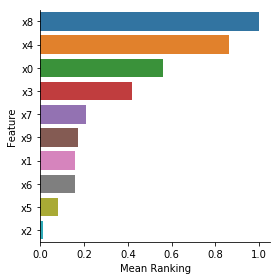

In [26]:
# Plot "Mean"
mean_plot = pd.DataFrame(list(r.items()), columns= ['Feature','Mean Ranking'])
# Sort the dataframe
mean_plot.sort_values('Mean Ranking', ascending=False, inplace=True)
# Plot the ranking of the features
sns.factorplot(x="Mean Ranking", y="Feature", data = mean_plot, kind="bar")

#### Note. the results at part 4 is quite different with that of part 2 and 3

## PART 5. Conclusion

#### Feature selection and ranking  needs to be used not only based on Machine Learning or Statistical methods but also (and sometimes more importantly) based on domain knowledge with the help of visualization. Because different ML or statistical methods usually will produce different results and we also need to interpret the results.


#### Based on the analysis in Part 1 as well as trying several methods in Part 2, 3, and 4; in this data set, I prefer to use "Random Forest Importance" in part 3. Therefore, my final ranking order is as below

>* Feature ranking:
* Rank 1. feature name:x6 (0.283595)
* Rank 2. feature name:x4 (0.223567)
* Rank 3. feature name:x8 (0.165509)
* Rank 4. feature name:x0 (0.144674)
* Rank 5. feature name:x3 (0.060599)
* Rank 6. feature name:x2 (0.036430)
* Rank 7. feature name:x1 (0.030416)
* Rank 8. feature name:x5 (0.021500)
* Rank 9. feature name:x9 (0.018366)
* Rank 10. feature name:x7 (0.015344)
>